In [1]:
#import files from local device
from google.colab import files
uploaded = files.upload()

Saving QVI_purchase_behaviour.csv to QVI_purchase_behaviour.csv
Saving QVI_transaction_data.xlsx to QVI_transaction_data.xlsx


In [2]:
# importing the libraries for analysis

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import warnings
warnings.filterwarnings('ignore')

In [3]:
#loading the datasets
purchase_df = pd.read_csv('QVI_purchase_behaviour.csv')
transaction_df = pd.read_excel('QVI_transaction_data.xlsx')

In [ ]:
#observing the data
purchase_df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [ ]:
transaction_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [ ]:
#getting additional information about the datasets
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [ ]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


From the datasets above, we have the purchase behaviour dataset which has 3 columns

LYLTY_CARD_NBR: shows the loyalty card number of the customer
LIFESTAGE: shows the lifestage the customer is in (whether at single or married, young or old etc.)
PREMIUM_CUSTOMER: customers segmented based on their purchase behaviours whether they are preium customers or budget customers etc..
There is one integer column and 2 object columns and no missing values.

The transaction dataset has 7 columns describing the date of transaction, the store number the purchase was made from, the loyalty card number of the customer, transaction id, product number, the name of the product the customer purchased, the quantity of the product purchased and the total price/sale done for this transaction.

There are no missing values for this dataset as well.

We'll perform some checks on the data to identify any inaccuracies in the both the datasets

In [ ]:
#checking for duplicate rows in the datasets
duplicate_df1 = purchase_df[purchase_df.duplicated()]
duplicate_df2 = transaction_df[transaction_df.duplicated()]

In [ ]:
print(duplicate_df1)

Empty DataFrame
Columns: [LYLTY_CARD_NBR, LIFESTAGE, PREMIUM_CUSTOMER]
Index: []


In [ ]:
print(duplicate_df2)

         DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
124845  43374        107          107024  108462        45   

                                     PROD_NAME  PROD_QTY  TOT_SALES  
124845  Smiths Thinly Cut   Roast Chicken 175g         2        6.0  


The transaction dataset has a duplicate entry but we can assume that the packet of Roast Chicken can be bought by the same person twice in a single transaction so we can keep this record.

In [ ]:
#checking for missing values
purchase_df.isna().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [ ]:
transaction_df.isna().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

Both the datasets don't have any missing values.

**Data Exploration:**

understanding the distribution of data and to identify any anomalies.

<Axes: xlabel='count', ylabel='LIFESTAGE'>

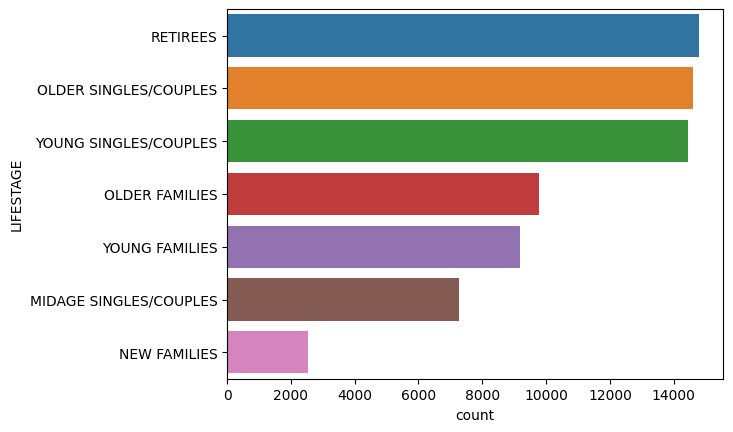

In [ ]:
#checking the distribution of lifestage and customer segments
sns.countplot(data = purchase_df, y = 'LIFESTAGE', order = purchase_df['LIFESTAGE'].value_counts().index)

<Axes: xlabel='count', ylabel='PREMIUM_CUSTOMER'>

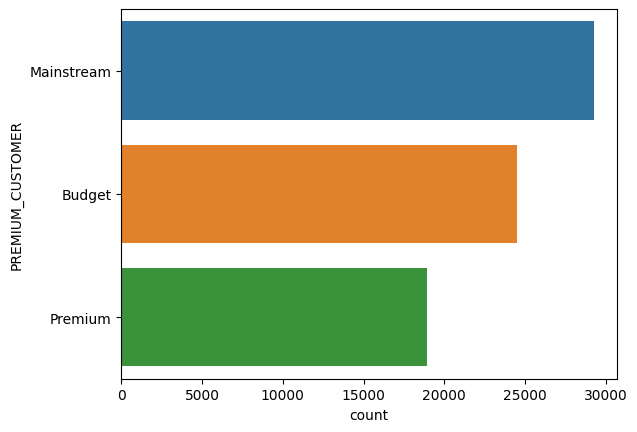

In [ ]:
sns.countplot(data = purchase_df, y = 'PREMIUM_CUSTOMER', order = purchase_df['PREMIUM_CUSTOMER'].value_counts().index)

From the above distribution, we can see the largest share of customers are the mainstream customers. With respect to the lifestage, we can see that most of the customers belong to young singles/couples, older singles/couples or retirees with the percentage of families being less.

In [4]:
#converting excel serial date to pandas datetime
transaction_df['DATE'] = pd.to_datetime(transaction_df['DATE'], unit='D',origin='1899-12-30')

Text(0.5, 1.0, 'Distribution of Product Quantity')

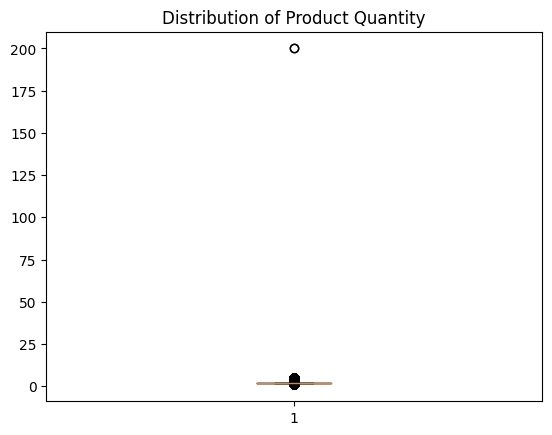

In [ ]:
#distribution of product Quantitity and Sales
plt.boxplot(transaction_df['PROD_QTY'])
plt.title('Distribution of Product Quantity')

Text(0.5, 1.0, 'Distribution of Total Sales')

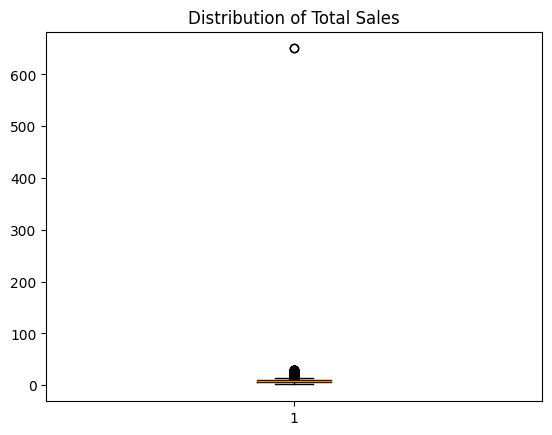

In [ ]:
#distribution of product Quantitity and Sales
plt.boxplot(transaction_df['TOT_SALES'])
plt.title('Distribution of Total Sales')

In [ ]:
#checking the details of the customer associated with the outlier
transaction_df[(transaction_df['PROD_QTY'] > 190) | (transaction_df['TOT_SALES'] > 600)]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [ ]:
#checking what other purchases this customer has done
transaction_df[transaction_df['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


From the distribution of total sales and product quantity, we can see that one customer seems to have placed an order with a very large quantity hence a higher sales value associated with it on two separate occasions. This could be a commerical customer. A further look needs to be done to see the lifestage or affluence level of this business.

Leaving this customer out from our analysis.

In [5]:
transaction_df_new = transaction_df[transaction_df['LYLTY_CARD_NBR'] != 226000]

In [6]:
#removing this customer from purchase dataset for now
purchase_df_new = purchase_df[purchase_df['LYLTY_CARD_NBR'] != 226000]

In [ ]:
#checking the unique values in PROD_NAME column
len(transaction_df_new['PROD_NAME'].unique())

114

There are 114 unique values in this column. Since our focus is on analyzing the chips purchasing behaviour, we will look at whether all of these values are chips or not. We will find out the commonly occuring words to find what are the products that we have.

In [ ]:
#frequency of words in products that do not contain Chip or Chp
non_chips = transaction_df_new[~(transaction_df_new['PROD_NAME'].str.contains('Chip')) & ~(transaction_df_new['PROD_NAME'].str.contains('Chp'))]
words = ' '.join(non_chips["PROD_NAME"])
Counter(words.split()).most_common()

[('175g', 35714),
 ('Kettle', 31708),
 ('150g', 25677),
 ('Pringles', 25102),
 ('134g', 25102),
 ('&', 24486),
 ('Cheese', 20004),
 ('Salsa', 18094),
 ('Salt', 15392),
 ('165g', 15297),
 ('Crinkle', 14848),
 ('Cut', 13225),
 ('110g', 12694),
 ('Crisps', 12607),
 ('Chilli', 12389),
 ('Original', 12382),
 ('300g', 12041),
 ('Smiths', 11988),
 ('RRD', 11894),
 ('Infuzions', 11057),
 ('Chicken', 10751),
 ('Twisties', 9454),
 ('Sensations', 9429),
 ('330g', 9343),
 ('Old', 9324),
 ('El', 9324),
 ('Paso', 9324),
 ('Dip', 9324),
 ('Sour', 9240),
 ('Doritos', 9088),
 ('Sweet', 7883),
 ('Sea', 7861),
 ('Lime', 7852),
 ('Tomato', 7669),
 ('Tyrrells', 6442),
 ('And', 6373),
 ('BBQ', 6351),
 ('Tostitos', 6326),
 ('Grain', 6272),
 ('Waves', 6272),
 ('Lightly', 6248),
 ('Salted', 6248),
 ('Cream', 6135),
 ('Vinegar', 6102),
 ('Mild', 6048),
 ('Red', 5885),
 ('Rock', 5885),
 ('Deli', 5885),
 ('Thai', 4737),
 ('Burger', 4733),
 ('Swt', 4718),
 ('Chives', 4687),
 ('Honey', 4661),
 ('Soy', 4661),
 ('Che

Based on the above frequency of words, we will identify some combinations of them to see which products are less likely to be chips.

In [7]:
#removing products that contain the words Salsa and Dip
transaction_df_new = transaction_df_new[~(transaction_df_new['PROD_NAME'].str.contains('Salsa')) & ~(transaction_df_new['PROD_NAME'].str.contains('Dip'))]

**Data Analysis**

In [8]:
# Now that the data issues are resolved, we can proceed to combine the two datasets
# combining records based on the customers present in transaction dataset
purchase_transaction_df = pd.merge(purchase_df_new, transaction_df_new, on='LYLTY_CARD_NBR', how = 'right')
purchase_transaction_df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,1307,MIDAGE SINGLES/COUPLES,Budget,2019-05-14,1,348,66,CCs Nacho Cheese 175g,3,6.3
2,1343,MIDAGE SINGLES/COUPLES,Budget,2019-05-20,1,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2373,MIDAGE SINGLES/COUPLES,Budget,2018-08-17,2,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2426,MIDAGE SINGLES/COUPLES,Budget,2018-08-18,2,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [9]:
#checking if there are any null values in the merged dataset
purchase_transaction_df.isna().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
dtype: int64

1) **Distribution of Stores by Number of Products**
- example: There are 35 stores selling upto 250 products.
- Stores selling products more than the average can be investigated to understand what factors about them - location, layout, product selection has attributed to high sales.

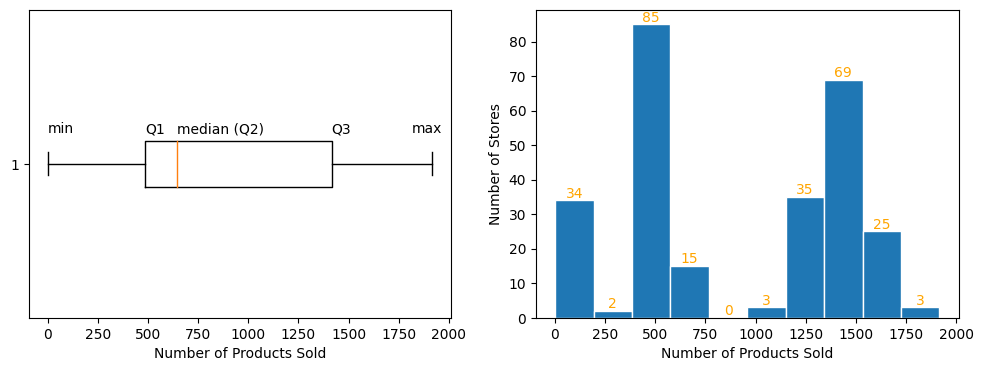

In [ ]:
count_products_by_stores = purchase_transaction_df.groupby(['STORE_NBR'], as_index=False).size().sort_values(by='size', ascending=False)
plt.figure(figsize=(12,4))
#boxplot
plt.subplot(1,2,1)
plt.boxplot(count_products_by_stores['size'], vert=False)
# add labels for five number summary
# x,y - coordinates of where we want to put the text, y coordinate is found through the data itself
# s - what text to mention
plt.text(y = 1.1, x = count_products_by_stores['size'].min(), s ='min')
plt.text(y = 1.1, x = count_products_by_stores['size'].quantile(0.25), s ='Q1')
plt.text(y = 1.1, x = count_products_by_stores['size'].median(), s ='median (Q2)')
plt.text(y = 1.1, x = count_products_by_stores['size'].quantile(0.75), s ='Q3')
plt.text(y = 1.1, x = count_products_by_stores['size'].max()-100, s ='max')
plt.xlabel('Number of Products Sold')
#histogram
plt.subplot(1,2,2)
values, bins, bars = plt.hist(count_products_by_stores['size'], edgecolor='white')
plt.xlabel('Number of Products Sold')
plt.ylabel('Number of Stores')
plt.bar_label(bars, fontsize=10, color='orange')
plt.show()

- The median number of chips sold by the stores are around 700 with the right skewed data suggesting that we have some stores selling a very high number of products. No stores observed as outliers in terms of the number of products sold.
- The distribution on the right shows we have two modes/peaks. More simply, it seems like we have a collection of stores where products sold are less than ~800 and a collection of stores where the products sold are ~1000. More analysis needs to be done as to why there is a division like this.

2) **Most Selling products for each store** - Shows the highest selling product for each store thereby indicating the consumer preference.

Text(0, 0.5, 'Number of times a product is sold in a Store')

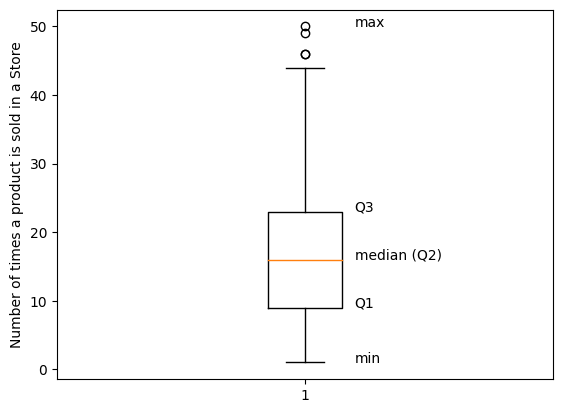

In [ ]:
tdf = purchase_transaction_df.groupby(['STORE_NBR', 'PROD_NBR'], as_index=False).size() #to get number of times each product is sold
tdf1 = tdf.groupby(['STORE_NBR']).agg({'size':'max'}) #the max number of product sold in a store for all stores
tdf1 = tdf1.reset_index()
tdf1 = tdf1.rename(columns={'size':'number_of_times_sold'})
tdf2 = pd.merge(tdf, tdf1, how='left', on='STORE_NBR')
products_by_store= tdf2[tdf2['size'] == tdf2['number_of_times_sold']] #fetching the products sold the max number of times
#boxplot
plt.boxplot(products_by_store['number_of_times_sold'])
# add labels for five number summary
# x,y - coordinates of where we want to put the text, y coordinate is found through the data itself
# s - what text to mention
plt.text(x = 1.1, y = products_by_store['number_of_times_sold'].min(), s ='min')
plt.text(x = 1.1, y = products_by_store['number_of_times_sold'].quantile(0.25), s ='Q1')
plt.text(x = 1.1, y = products_by_store['number_of_times_sold'].median(), s ='median (Q2)')
plt.text(x = 1.1, y = products_by_store['number_of_times_sold'].quantile(0.75), s ='Q3')
plt.text(x = 1.1, y = products_by_store['number_of_times_sold'].max(), s ='max')
plt.ylabel('Number of times a product is sold in a Store')

From the above distribution of most selling products for each store, we find that there are some outliers. We will next look at which products are these who are being sold in such high numbers and in which stores these products are being sold. The outlier products have the sales number greater than ~45.

In [ ]:
#fetching products which have been sold more than 45 times
outlier_products = products_by_store[products_by_store['number_of_times_sold']>45]
outlier_products.insert(4, 'Product_name', pd.merge(outlier_products, transaction_df, how='left', on=['STORE_NBR','PROD_NBR']).PROD_NAME.unique())
outlier_products

,STORE_NBR,PROD_NBR,size,number_of_times_sold,Product_name
4610,58,60,46,46,Kettle Tortilla ChpsFeta&Garlic 150g
6764,88,31,50,50,Infzns Crn Crnchers Tangy Gcamole 110g
15935,203,88,46,46,Kettle Honey Soy Chicken 175g
17661,226,112,49,49,Tyrrells Crisps Ched & Chives 165g


The above products are outliers in terms of the maximum selling product of a store. These brands and flavours are the ones consumers have preferred the most. Placement of these products in these stores can be studied as well as further exploration of which customer segments preferred them. This can potentially help in understanding which other stores can benefit from having these items.

3) **Breakdown of lifestages based on segments in PREMIUM_CUSTOMER** - The breakdown of lifestages w.r.t premium customer can help in understanding the affluence levels in each lifestage i.e. which lifestage is more or less budget conscious.

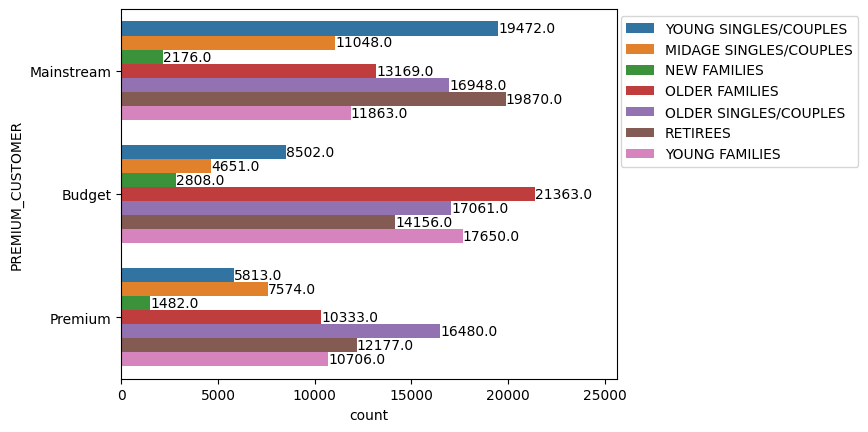

In [77]:
#setting the colours for the legend
palette_colors = sns.color_palette('tab10')
lifestages = purchase_transaction_df.LIFESTAGE.unique()
palette_dict = {lifestage: color for lifestage, color in zip(lifestages, palette_colors)}

ax = sns.countplot(data = purchase_transaction_df, y = 'PREMIUM_CUSTOMER', hue= 'LIFESTAGE', palette = palette_dict, hue_order= lifestages, order = purchase_transaction_df['PREMIUM_CUSTOMER'].value_counts().index)
# add annotations
for c in ax.containers:
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h:0.1f}' if (h := v.get_width()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')
ax.margins(x=0.2)
plt.legend(bbox_to_anchor=(1.5, 1))
plt.show() # display the plot

4) **Sales by Lifestage and Segment**: To understand the purchasing behaviour of customers, we'll look at the Sales done across different lifestages and segments to identify their buying patterns.

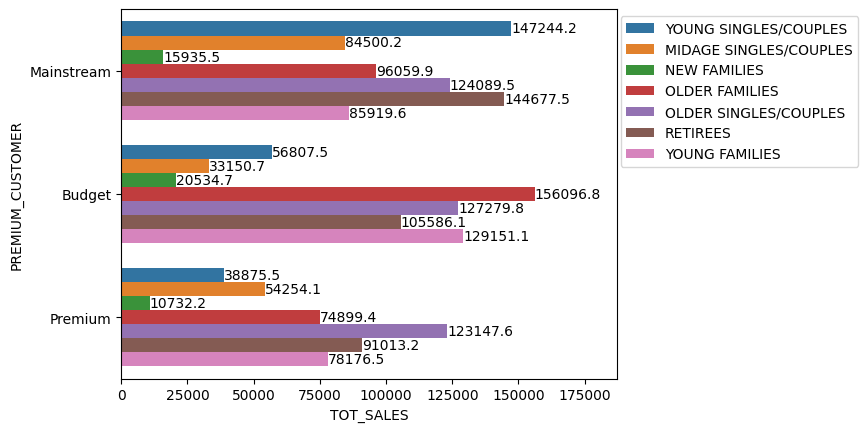

In [78]:
tot_sales_segment = purchase_transaction_df.groupby(['PREMIUM_CUSTOMER','LIFESTAGE'])['TOT_SALES'].sum().to_frame()
tot_sales_segment = tot_sales_segment.reset_index()
ax = sns.barplot(data = tot_sales_segment, x='TOT_SALES', y = 'PREMIUM_CUSTOMER', hue= 'LIFESTAGE', palette = palette_dict, hue_order= lifestages, order = purchase_transaction_df['PREMIUM_CUSTOMER'].value_counts().index)
# add annotations
for c in ax.containers:
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h:0.1f}' if (h := v.get_width()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')
ax.margins(x=0.2)
plt.legend(bbox_to_anchor=(1.5, 1))
plt.show() # display the plot

- The maximum sales are coming from Mainstream - Young Singles/Couples, Mainstream - Retirees and Budget - Older Families.
- The Sales numbers seem to be proportional to the population within the segment. So for example, for Mainstream, Young Singles/Couples and Retirees have the maximum population which is reflected in the sales numbers as well. A similar trend is observed for the other lifestages across Mainstream, Premium and Budget customers.
- Mainstream Young Singles/Couples have a slightly lower population than Mainstream Retirees but a slightly higher sales number. Thus to see which lifestage spends more on chips, there can be two factors:
  - Average Price per unit of Chips is higher for the lifestage, hence a higher overall sales number.
  - Number of Chips bought per customer are higher hence a higher overall sales number.
We'll look at both these factors for all the lifestages to further examine their purchase behaviour.

5) **Number of Chips bought per customer by lifestage and segments**

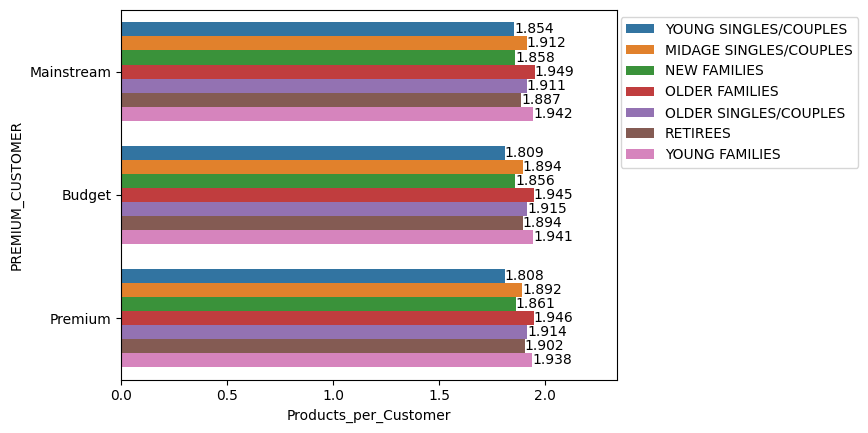

In [79]:
#calculating the number of products per customer for each lifestage
number_products_per_segment = purchase_transaction_df.groupby(['PREMIUM_CUSTOMER','LIFESTAGE'])['PROD_QTY'].sum().to_frame().reset_index()
number_customers_per_segment = purchase_transaction_df.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).size().to_frame().reset_index()
number_customers_per_segment = number_customers_per_segment.rename(columns={0:'Number_of_Customers'})
number_products_per_segment['Products_per_Customer'] = number_products_per_segment['PROD_QTY']/number_customers_per_segment['Number_of_Customers']

#plotting the result
ax = sns.barplot(data = number_products_per_segment, x='Products_per_Customer', y = 'PREMIUM_CUSTOMER', hue= 'LIFESTAGE', palette = palette_dict, hue_order= lifestages, order = purchase_transaction_df['PREMIUM_CUSTOMER'].value_counts().index)
for c in ax.containers:
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h:0.3f}' if (h := v.get_width()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')
ax.margins(x=0.2)
plt.legend(bbox_to_anchor=(1.5, 1))
plt.show() # display the plot


- Older Families and Young Families generally purchase more products per customer than other lifestages
- For MainStream Young Singles/Couples, the prodcuts purchased per customer is lesser than other lifestages but the overall sales were more. This might indicate that they are average spend is higher which we'll investigate next.

6) **Average sales per customer by lifestage and segment**

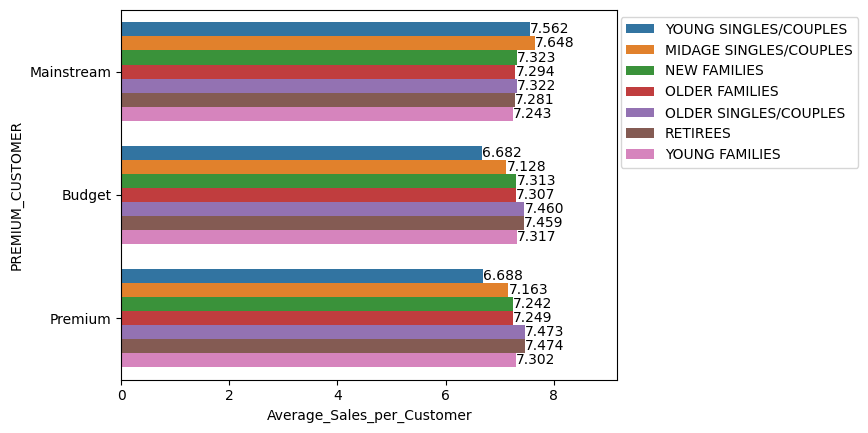

In [81]:
#calculating the number of products per customer for each lifestage
tot_sales_segment['Average_Sales_per_Customer'] = tot_sales_segment['TOT_SALES']/number_customers_per_segment['Number_of_Customers']

#plotting the result
ax = sns.barplot(data = tot_sales_segment, x='Average_Sales_per_Customer', y = 'PREMIUM_CUSTOMER', hue= 'LIFESTAGE', palette = palette_dict, hue_order= lifestages, order = purchase_transaction_df['PREMIUM_CUSTOMER'].value_counts().index)
for c in ax.containers:
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h:0.3f}' if (h := v.get_width()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')
ax.margins(x=0.2)
plt.legend(bbox_to_anchor=(1.5, 1))
plt.show() # display the plot

- Mainstream Young Singles/Couples and Mainstream Midage Singles/Couples have the highest average sales per customers spending more than their counterparts in Budget and Premium.
- In both Budget and Premium category, older singles/couples and retirees have the highest average spend with the average sales amount similar in both categories.
- For the other lifestages apart from the ones mentioned above, the spend is similar across the three categories. So we'll compare whether the difference between the spend for Mainstream Young Singles/Couples and Midage Singles/Couples with their budget and premium counterparts is significant or not.

7) **Comparing Mainstream Young Singles/Couples with their Budget and Premium counterparts**

Since the Budget and Premium spend is the same we'll just compare one of them with Mainstream Young Singles/Couples.

Establishing our Null and Alternate Hypothesis.

$\mu_1$ = Average Price of Mainstream Young Singles/Couples

$\mu_2$ = Average Price of Premium/Budget Young Singles/Couples

Null:
>$H_0:\mu_1=\mu_2$

Alternate:
>$H_a:\mu_1>\mu_2$

In [ ]:
Mainstream_young = purchase_transaction_df[(purchase_transaction_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (purchase_transaction_df['PREMIUM_CUSTOMER'] == 'Mainstream')]['TOT_SALES']
Premium_young = purchase_transaction_df[(purchase_transaction_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (purchase_transaction_df['PREMIUM_CUSTOMER'] == 'Premium')]['TOT_SALES']

#checking the standard deviation of sales of Mainstream young singles/couples and premium young singles/couples to decide the type of t-test
print('Standard deviation of Mainstream Young Singles/Couples', Mainstream_young.std())
print('Standard deviation of Premium Young Singles/Couples', Premium_young.std())

Standard deviation of Mainstream Young Singles/Couples 2.463408855561709
Standard deviation of Premium Young Singles/Couples 2.6447285896630532


given the standard deviation of Mainstream Young Singles/Couples and Premium/Budget Young Singles/Couples are not equal we'll go with the unequal std t-test(Welch's t-test).

Assumptions of t-test:
- Continous Data: The data we are dealing with are price of items purchased by customers which is continous
- Normally distributed populations: Since the sample size is > 30, so according to Central Limit Theorem the distrbution of sample means will be normal.
- Independent populations: As we are taking random samples for two different types of users, the two samples are from two independent populations.
- Unequal population standard deviations: As the sample standard deviations are unequal, the population standard deviations can be assumed to be unequal.
- Since we have no information of data collection, in this case given the above conditions we are assuming this sample as a simple random sample.

Given the assumption of the t-test are met we can proceed with the test. Assuming a significance level of 5%

In [ ]:
# find the p-value
test_stat, p_value = ttest_ind(Mainstream_young, Premium_young, equal_var = False, alternative = 'greater')
print('The p-value is ', float(p_value))

The p-value is  4.74302373424734e-109


Based on the above p-value which is much less than 0.05, we can say that the Average price per unit spent for Mainstream Young Singles/Couples is higher than their Budget/Premium counterparts and the difference is statistically significant.

Now doing the same calculations as above for Mainstream Midage Singles/Couples vs their Premium/Budget Counterparts.

Since the Budget and Premium spend is the same we'll just compare one of them with Mainstream Midage Singles/Couples.

Establishing our Null and Alternate Hypothesis.

$\mu_1$ = Average Price of Mainstream Midage Singles/Couples

$\mu_2$ = Average Price of Premium/Budget Midage Singles/Couples

Null:
>$H_0:\mu_1=\mu_2$

Alternate:
>$H_a:\mu_1>\mu_2$

In [ ]:
Mainstream_midage = purchase_transaction_df[(purchase_transaction_df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') & (purchase_transaction_df['PREMIUM_CUSTOMER'] == 'Mainstream')]['TOT_SALES']
Premium_midage = purchase_transaction_df[(purchase_transaction_df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') & (purchase_transaction_df['PREMIUM_CUSTOMER'] == 'Premium')]['TOT_SALES']

#checking the standard deviation of sales of Mainstream young singles/couples and premium young singles/couples to decide the type of t-test
print('Standard deviation of Mainstream Young Singles/Couples', Mainstream_midage.std())
print('Standard deviation of Premium Young Singles/Couples', Premium_midage.std())

Standard deviation of Mainstream Young Singles/Couples 2.411545629145507
Standard deviation of Premium Young Singles/Couples 2.527713382035746


Assuming the above assumptions of the t-test in case of Mainstream Young Singles/Couples should be valid be Mainstream Midage Singles/Couples as well. Thus proceeding towards calculating the p-value at a significance level of 5%.

In [ ]:
# find the p-value
test_stat, p_value = ttest_ind(Mainstream_midage, Premium_midage, equal_var = False, alternative = 'greater')
print('The p-value is ', float(p_value))

The p-value is  2.2886822412011976e-39


Based on the above p-value which is much less than 0.05, we can say that the Average price per unit spent for Mainstream Midage Singles/Couples is higher than their Budget/Premium counterparts and the difference is statistically significant.

8) **Deep Dive into identified Segments:** From the above metrics, we have identified some segments that have either a higher sales, higher average spend or higher number of products purchased per customer. We'll look at their preferences, such as preferred brands and preferred package size.



In [ ]:
#extracting the first name to get the brand name
brand_names= purchase_transaction_df['PROD_NAME'].str.split(" ").to_frame()['PROD_NAME'].str[0:1].to_frame()
brand_names = brand_names['PROD_NAME'].str.join(' ').to_frame()
brand_names['PROD_NAME'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

From the list of brand names above, we can see that some brand names are the same but have different abbrevations like Red(Red rock deli) and RRD are the same and the same can be said about Infzns and Infuzions, Dorito and Doritos etc.

In [ ]:
# adjusting the brand names
brand_names.loc[brand_names['PROD_NAME'] == 'Grain', 'PROD_NAME'] = 'GrnWves'
brand_names.loc[brand_names['PROD_NAME'] == 'Red', 'PROD_NAME'] = 'RRD'
brand_names.loc[brand_names['PROD_NAME'] == 'Dorito', 'PROD_NAME'] = 'Doritos'
brand_names.loc[brand_names['PROD_NAME'] == 'Snbts', 'PROD_NAME'] = 'Sunbites'
brand_names.loc[brand_names['PROD_NAME'] == 'Smith', 'PROD_NAME'] = 'Smiths'
brand_names.loc[brand_names['PROD_NAME'] == 'Infzns', 'PROD_NAME'] = 'Infuzions'
brand_names.loc[brand_names['PROD_NAME'] == 'NCC', 'PROD_NAME'] = 'Natural'

In [ ]:
#adding the column to our main dataset
purchase_transaction_df['Brand_Name'] = brand_names
purchase_transaction_df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Brand_Name
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,Natural
1,1307,MIDAGE SINGLES/COUPLES,Budget,2019-05-14,1,348,66,CCs Nacho Cheese 175g,3,6.3,CCs
2,1343,MIDAGE SINGLES/COUPLES,Budget,2019-05-20,1,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,Smiths
3,2373,MIDAGE SINGLES/COUPLES,Budget,2018-08-17,2,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,Smiths
4,2426,MIDAGE SINGLES/COUPLES,Budget,2018-08-18,2,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,Kettle


In [ ]:
brand_names = brand_names['PROD_NAME'].unique()
brand_names

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'GrnWves', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'Cheezels', 'Infuzions',
       'RRD', 'Pringles', 'Tyrrells', 'Cobs', 'French', 'Tostitos',
       'Cheetos', 'Woolworths', 'Sunbites'], dtype=object)

In [ ]:
#extracting the digits of pack size from the product names
product_size= purchase_transaction_df['PROD_NAME'].str.extract('(\d+)')
purchase_transaction_df['product_size'] = product_size
purchase_transaction_df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Brand_Name,product_size
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,Natural,175
1,1307,MIDAGE SINGLES/COUPLES,Budget,2019-05-14,1,348,66,CCs Nacho Cheese 175g,3,6.3,CCs,175
2,1343,MIDAGE SINGLES/COUPLES,Budget,2019-05-20,1,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,Smiths,170
3,2373,MIDAGE SINGLES/COUPLES,Budget,2018-08-17,2,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,Smiths,175
4,2426,MIDAGE SINGLES/COUPLES,Budget,2018-08-18,2,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,Kettle,150


In [ ]:
product_sizes = purchase_transaction_df['product_size'].unique()
product_sizes

array(['175', '170', '150', '330', '210', '270', '220', '125', '110',
       '134', '380', '180', '165', '135', '250', '200', '160', '190',
       '90', '70'], dtype=object)

Looking at the brand preferences of our target segments from above and whether there are some brands for which their affinity is higher than the other segments.

preference for a brand(or another attribute under consideration) is calculated by checking the total quantity of that brand bought by the target customer segment as a proportion of all the brands bought by that target customer segment.

affinity is the ratio of preference value of target customer segment and prefernce value for rest of the customer segments. This ratio will show how much higher or lower the preference for a brand for a target customer segment is as compared to the rest of the customer segments.

In [ ]:
#checking affinity for a target segment
def affinity(premium_customer, lifestage, attribute, attribute_values):
  affinity_for_segments = pd.DataFrame()
  preference_values_target = []
  preference_values_others = []
  affinity_values = []
  target_segment = purchase_transaction_df[(purchase_transaction_df['PREMIUM_CUSTOMER'] == premium_customer) & (purchase_transaction_df['LIFESTAGE'] == lifestage)].loc[:,[attribute,'PROD_QTY']]
  other_segments = purchase_transaction_df[(purchase_transaction_df['PREMIUM_CUSTOMER'] != premium_customer) & (purchase_transaction_df['LIFESTAGE'] != lifestage)].loc[:,[attribute,'PROD_QTY']]
  sum_prod_qty_target = target_segment['PROD_QTY'].sum()
  sum_prod_qty_others = other_segments['PROD_QTY'].sum()
  for attribute_value in attribute_values:
    preference_value_target = target_segment[target_segment[attribute] == attribute_value]['PROD_QTY'].values.sum()/sum_prod_qty_target
    preference_value_others = other_segments[other_segments[attribute] == attribute_value]['PROD_QTY'].values.sum()/sum_prod_qty_others
    affinity_to_brand = preference_value_target/preference_value_others
    preference_values_target.append(preference_value_target)
    preference_values_others.append(preference_value_others)
    affinity_values.append(affinity_to_brand)
  affinity_for_segments[attribute] = attribute_values
  affinity_for_segments['preference_target'] = preference_values_target
  affinity_for_segments['preference_others'] = preference_values_others
  affinity_for_segments['affinity_to_brand'] = affinity_values
  return affinity_for_segments.sort_values(by='affinity_to_brand')

- Mainstream Young Singles/Couples

In [ ]:
affinity('Mainstream','YOUNG SINGLES/COUPLES','Brand_Name',brand_names)

,Brand_Name,preference_target,preference_others,affinity_to_brand
9,Burger,0.002937,0.006577,0.446488
19,Woolworths,0.002854,0.006127,0.465749
7,WW,0.021333,0.042915,0.497092
20,Sunbites,0.006372,0.012689,0.502177
1,CCs,0.011220,0.018556,0.604671
0,Natural,0.019670,0.031146,0.631555
12,RRD,0.043967,0.067590,0.650498
18,Cheetos,0.008062,0.011830,0.681492
16,French,0.003962,0.005741,0.690046
2,Smiths,0.093115,0.118926,0.782969


- For Mainstream Young Singles/Couples, their affinity for Tyrells is 23% higher than the other segments followed by Doritos and Twisties at 21%
- The least preferred brand is Burger for which their affinity is 56% less than the other segments.

- Mainstream Midage Singles/Couples

In [ ]:
affinity('Mainstream','MIDAGE SINGLES/COUPLES','Brand_Name',brand_names)

,Brand_Name,preference_target,preference_others,affinity_to_brand
20,Sunbites,0.006249,0.012772,0.489268
7,WW,0.027127,0.043685,0.620961
16,French,0.003835,0.005905,0.649448
9,Burger,0.004355,0.006554,0.664517
19,Woolworths,0.004355,0.006399,0.680601
1,CCs,0.014487,0.018881,0.767261
0,Natural,0.024760,0.031362,0.789472
12,RRD,0.054490,0.068255,0.798332
18,Cheetos,0.010178,0.011972,0.850226
2,Smiths,0.111395,0.119961,0.928598


- For Mainstream Midage Singles/Couples, their most preferred brands are Cobs and Kettle with the affinity for them being 16% higher than the others followed by Twisties at 15% higher affinity than the others.
- least preferred brand is sunbites, 52% less than the others.

Next we'll look at the package sizes preferred by these two segments

In [ ]:
affinity('Mainstream','YOUNG SINGLES/COUPLES','product_size',product_sizes)

,product_size,preference_target,preference_others,affinity_to_brand
6,220,0.002937,0.006577,0.446488
19,70,0.003048,0.006322,0.482083
15,200,0.009004,0.018583,0.484532
18,90,0.006372,0.012689,0.502177
7,125,0.003020,0.006012,0.502268
16,160,0.006427,0.012296,0.522741
11,180,0.003602,0.006215,0.579533
17,190,0.007508,0.012204,0.615200
12,165,0.055853,0.061960,0.901436
0,175,0.255908,0.273098,0.937056


- For Mainstream young singles/couples, 270g is the package size they prefer the most, their preference being 26% higher than the other segments follwed by 380g which is 24% higher.
- least preferred size for them is 220g which is 56% less than the others

In [ ]:
affinity('Mainstream','MIDAGE SINGLES/COUPLES','product_size',product_sizes)

,product_size,preference_target,preference_others,affinity_to_brand
18,90,0.006249,0.012772,0.489268
7,125,0.003219,0.006226,0.517094
15,200,0.012119,0.018960,0.639206
6,220,0.004355,0.006554,0.664517
11,180,0.004261,0.006241,0.682732
19,70,0.004545,0.006418,0.708102
16,160,0.009090,0.012599,0.721479
17,190,0.010368,0.012466,0.831665
12,165,0.057331,0.062162,0.922283
1,170,0.079724,0.081175,0.982119


- For Mainstream Midage Singles/Couples, 270g is the most preffered size, 23% higher than the others.
- 90g is the least preffered size for them

- Since twisties and 270g size are preferred by both of the above segments, we'll look at who offers 270g pack sizes.

In [ ]:
purchase_transaction_df[purchase_transaction_df['product_size'] == '270']['Brand_Name'].unique()

array(['Twisties'], dtype=object)

- Twisties is the only brand offering 270g and is preferred by both

5) **Price preference for different lifestages over years**

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, '2018-07'),
  Text(1, 0, '2018-08'),
  Text(2, 0, '2018-09'),
  Text(3, 0, '2018-10'),
  Text(4, 0, '2018-11'),
  Text(5, 0, '2018-12'),
  Text(6, 0, '2019-01'),
  Text(7, 0, '2019-02'),
  Text(8, 0, '2019-03'),
  Text(9, 0, '2019-04'),
  Text(10, 0, '2019-05'),
  Text(11, 0, '2019-06')])

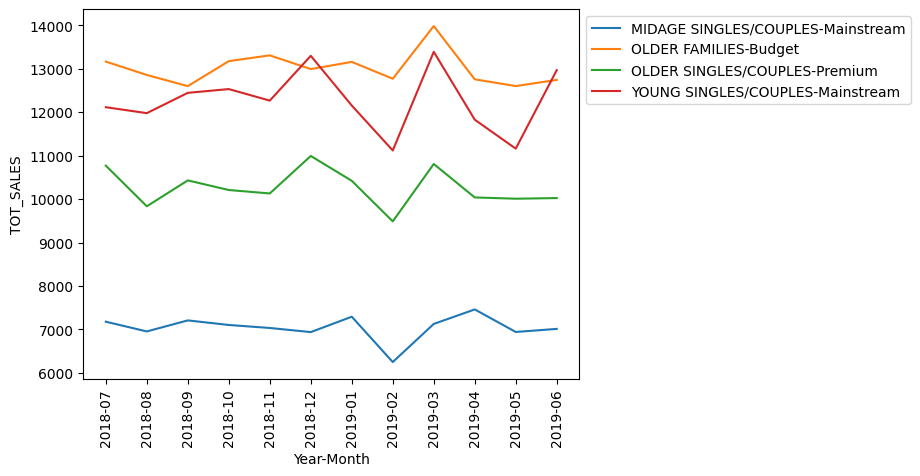

In [ ]:
#extracting year and month from Date
purchase_transaction_df['Year-Month'] = purchase_transaction_df['DATE'].dt.to_period('M')
#combining lifestage and premium customer column for vizualization purposes
target_segments = purchase_transaction_df[((purchase_transaction_df['PREMIUM_CUSTOMER'] == 'Mainstream') &
 (purchase_transaction_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')) | ((purchase_transaction_df['PREMIUM_CUSTOMER'] == 'Mainstream') &
 (purchase_transaction_df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES')) | ((purchase_transaction_df['PREMIUM_CUSTOMER'] == 'Budget') &
 (purchase_transaction_df['LIFESTAGE'] == 'OLDER FAMILIES')) | ((purchase_transaction_df['PREMIUM_CUSTOMER'] == 'Premium') &
 (purchase_transaction_df['LIFESTAGE'] == 'OLDER SINGLES/COUPLES'))]
target_segments['target_segment'] = target_segments[['LIFESTAGE', 'PREMIUM_CUSTOMER']].agg('-'.join, axis=1)
#checking the total sales for each lifestage by month for the years 2018 and 2019
sales_by_month = target_segments.groupby(['target_segment','Year-Month'])['TOT_SALES'].sum().to_frame()
sales_by_month = sales_by_month.reset_index()
sales_by_month = sales_by_month.astype({'Year-Month': 'str'})
sns.lineplot(data = sales_by_month, x='Year-Month', y= 'TOT_SALES', hue = sales_by_month['target_segment'])
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)

- There is drop in sales for all the lifestages in the month of Feb for 2019 and a subsequent increase in March. It would be worth investigating as what event triggered that fall in Feb 2019.


In [ ]:
purchase_transaction_df.to_excel('transactions.xlsx', index=False)

**Conclusions**

- The customer bringing in the most sales are Mainstream young singles/couples, Mainstream retirees and Budget older families.
- The sales numbers are proportional to the number of people in these segments so generally, the segments with higher numbers have the larger sales.
- Mainstream young singles/couples and Mainstream midage singles/couples have the highest average sale per customer. They are more likely to have the impulsivity to buy higher priced chips.
-  Tyrells, Doritos and Twisties are the preferred brands for Mainstream Young Singles/Couples. These brands could be placed in the areas frequented by this segment.
- Tyrells, Doritos and Twisties are the preferred brands for Mainstream Young Singles/Couples. These brands could be placed in the areas frequented by this segment.
- Cobs, Kettle and Twisties is the most preferred for Mainstream Midage Singles/Couples.
- 270g pack of twisties is preferred by both Mainstream Young Singles/Couples and Midage Singles/Couples. Bundle packs or promo offers as well placing them strategically in areas of stores frequented by these two segments could be useful.